<a href="https://colab.research.google.com/github/Anya232536/study_hse/blob/main/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy
import simpy
import random
import itertools
import numpy as np

In [ ]:
import simpy
import random
import numpy as np
import itertools
import matplotlib.pyplot as plt

RANDOM_SEED = 42
NUM_MACHINES = 2
WASHTIME = 2/3 # Среднее время обслуживания
lamda = 3       # Интенсивность поступления заявок
m = 2           # Количество каналов обслуживания
SIM_TIME = 400

# Метрики
total_arrivals = []
rejected_cars = []
wait_times = []
total_time_system = []
service_times = []
queue_lengths_with_times = []
system_occupancy_with_times = []
busy_periods = []
without_queue_cars = []





class Carwash:
    def __init__(self, env, num_machines, washtime, rng):
        self.env = env
        self.machine = simpy.Resource(env, num_machines)
        self.washtime = washtime
        self.rng = rng
        self.last_busy_end = 0
        self.first_car_served = True

    def wash(self, car):
        yield self.env.timeout(self.rng.exponential(self.washtime))
        print(f"Carwash removed {car}'s dirt.")

    def track_busy_periods(self, current_time):
        if len(self.machine.users) == 0 and len(self.machine.queue) == 0:
            if self.last_busy_end > 0:
                self.busy_periods.append(current_time - self.last_busy_end)
                print(f"Busy period ended at {current_time:.2f}.")
            self.last_busy_end = current_time

    def check_end_of_simulation(self):
        # Проверяем состояние системы в конце симуляции
        if len(self.machine.users) > 0 or len(self.machine.queue) > 0:
            self.busy_periods.append(self.env.now - self.last_busy_end)
            print(f"Busy period continued till the end at {self.env.now:.2f}.")
            self.last_busy_end = self.env.now



def car(env, name, cw):
    arrival_time = env.now
    total_arrivals.append(arrival_time)
    queue_lengths_with_times.append((env.now, len(cw.machine.queue))) # Добавляем длину очереди при прибытии
    system_occupancy_with_times.append((env.now, len(cw.machine.queue) + len(cw.machine.users))) # Количество в системе при прибытии

    if len(cw.machine.users) < NUM_MACHINES:
        without_queue_cars.append(1)

    if not cw.first_car_served:  # Только что начали обслуживать
                cw.last_busy_end = arrival_time
                cw.first_car_served = True


    if len(cw.machine.queue) >= m:
        print(f'{name} leaves without washing (queue full) at {env.now:.2f}.')
        rejected_cars.append(1)
        wait_times.append(0)
        service_times.append(0)
        total_time_system.append(0)
        queue_lengths_with_times.append((env.now, len(cw.machine.queue))) #Добавляем длину очереди при уходе
    else:
        with cw.machine.request() as request:

            yield request
            start_service_time = env.now
            wait_times.append(start_service_time - arrival_time)
            print(f'{name} enters the carwash at {start_service_time:.2f}.')

            yield env.process(cw.wash(name))
            end_service_time = env.now
            service_times.append(end_service_time - start_service_time)
            print(f'{name} leaves the carwash at {end_service_time:.2f}.')
            total_time_system.append(end_service_time - arrival_time)
            queue_lengths_with_times.append((end_service_time, len(cw.machine.queue))) #Добавляем длину очереди при уходе
            system_occupancy_with_times.append((end_service_time, len(cw.machine.queue) + len(cw.machine.users))) # Количество в системе при уходе

            cw.track_busy_periods(end_service_time)




def setup(env, num_machines, washtime, lamda):
    rng = np.random.default_rng(RANDOM_SEED)
    carwash = Carwash(env, num_machines, washtime, rng)
    car_count = itertools.count()
    env.process(car(env, f'Car {next(car_count)}', carwash))
    while True:
        yield env.timeout(rng.exponential(1 / lamda))
        env.process(car(env, f'Car {next(car_count)}', carwash))

    env.process(carwash.check_end_of_simulation())



random.seed(RANDOM_SEED)
env = simpy.Environment()
env.process(setup(env, NUM_MACHINES, WASHTIME, lamda))
env.run(until=SIM_TIME)


wait_times_intervals = []
stay_times_intervals = []

if len(queue_lengths_with_times) > 1:
    for i in range(len(queue_lengths_with_times) -1):
        t1, q1 = queue_lengths_with_times[i]
        t2, q2 = queue_lengths_with_times[i+1]
        if q1 > 0 and q2 == 0: # Заявка ушла из очереди
            wait_times_intervals.append(t2-t1)
        elif q1 == 0 and q2 > 0: # Заявка пришла
            pass #пропускаем моменты прихода
        elif q1 > 0 and q2 >0: #Заявка в очереди
            pass
        elif q1==0 and q2 ==0:
            pass

    for i in range(len(system_occupancy_with_times) - 1):
        t1, s1 = system_occupancy_with_times[i]
        t2, s2 = system_occupancy_with_times[i+1]
        if s1 > 0 and s2 == 0: # Заявка покинула систему
          stay_times_intervals.append(t2 - t1)


# Взвешенное среднее количества заявок в очереди
weighted_sum_queue = 0
total_weight_queue = 0
if len(queue_lengths_with_times)>1:
    for i in range(len(queue_lengths_with_times) - 1):
        queue_len = queue_lengths_with_times[i][1]
        weight = queue_lengths_with_times[i+1][0] - queue_lengths_with_times[i][0]
        weighted_sum_queue += queue_len * weight
        total_weight_queue += weight
    weighted_avg_queue = weighted_sum_queue / total_weight_queue if total_weight_queue > 0 else 0
else:
    weighted_avg_queue = 0


# Взвешенное среднее количества заявок в СМО
weighted_sum_system = 0
total_weight_system = 0
if len(system_occupancy_with_times) > 1:
    for i in range(len(system_occupancy_with_times) - 1):
        system_occupancy = system_occupancy_with_times[i][1]
        weight = system_occupancy_with_times[i+1][0] - system_occupancy_with_times[i][0]
        weighted_sum_system += system_occupancy * weight
        total_weight_system += weight
    weighted_avg_system = weighted_sum_system / total_weight_system
else:
    weighted_avg_system = 0





Car 0 enters the carwash at 0.00.
Car 1 enters the carwash at 0.80.
Carwash removed Car 1's dirt.
Car 1 leaves the carwash at 0.99.
Carwash removed Car 0's dirt.
Car 0 leaves the carwash at 1.56.
Car 2 enters the carwash at 1.60.
Car 3 enters the carwash at 1.63.
Car 6 leaves without washing (queue full) at 2.47.
Car 7 leaves without washing (queue full) at 2.49.
Carwash removed Car 2's dirt.
Car 2 leaves the carwash at 2.56.
Car 4 enters the carwash at 2.56.
Car 9 leaves without washing (queue full) at 2.99.
Car 10 leaves without washing (queue full) at 3.40.
Car 11 leaves without washing (queue full) at 3.45.
Car 12 leaves without washing (queue full) at 3.48.
Car 13 leaves without washing (queue full) at 3.58.
Carwash removed Car 3's dirt.
Car 3 leaves the carwash at 3.71.
Car 5 enters the carwash at 3.71.
Carwash removed Car 4's dirt.
Car 4 leaves the carwash at 3.72.
Car 8 enters the carwash at 3.72.
Carwash removed Car 5's dirt.
Car 5 leaves the carwash at 3.98.
Car 14 enters the

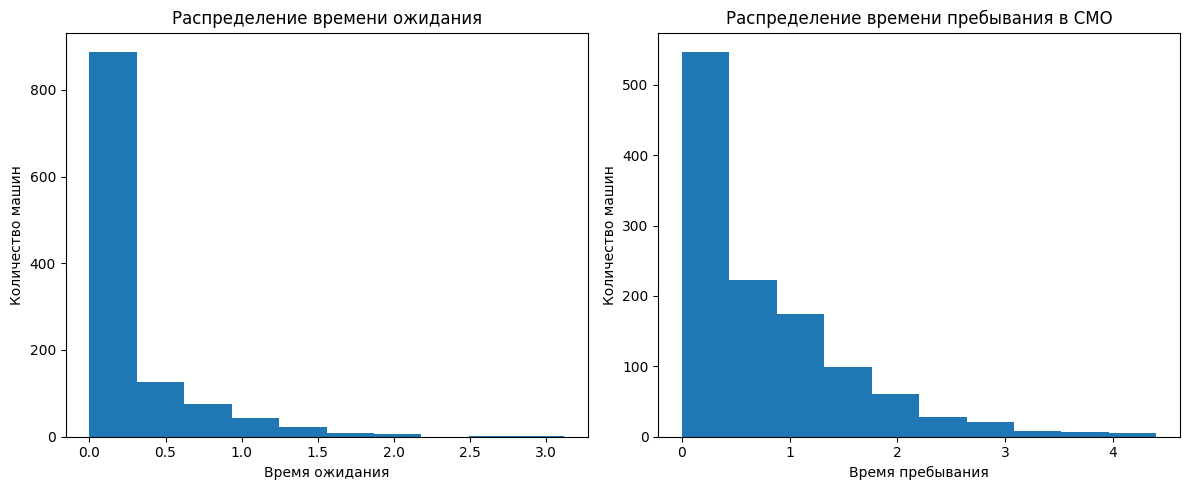

A: 2.31
Q: 0.79
CFR utilization rate:1.000
Wait time in queue: 0.218
Wait time in system: 0.737
Probability of failure: 0.214
Probability of without queue: 0.356
Weighted average queue length: 0.65
Weighted average number of cars in the system: 2.23


In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(wait_times, bins=10)
plt.title('Распределение времени ожидания')
plt.xlabel('Время ожидания')
plt.ylabel('Количество машин')

plt.subplot(1, 2, 2)
plt.hist(total_time_system, bins=10)
plt.title('Распределение времени пребывания в СМО')
plt.xlabel('Время пребывания')
plt.ylabel('Количество машин')

plt.tight_layout()
plt.show()

# Вывод результатов
print(f"A: {(len(total_arrivals) - len(rejected_cars))/SIM_TIME:.2f}") #абсолютное время симуляции
print(f"Q: {(len(total_arrivals) - len(rejected_cars))/len(total_arrivals):.2f}") #относительное время симуляции
print(f"CFR utilization rate:{(SIM_TIME if len(busy_periods) == 0 else sum(busy_periods)) / (SIM_TIME):.3f}") #коэффициент использование СМО
print(f"Wait time in queue: {np.mean(wait_times):.3f}") #среднее время в очереди
print(f"Wait time in system: {np.mean(total_time_system):.3f}") #среднее время в системе
print(f"Probability of failure: {len(rejected_cars)/len(total_arrivals):.3f}") #вероятность отказа
print(f"Probability of without queue: {(len(without_queue_cars)/len(total_arrivals)):.3f}") #вероятность того, что машина будет обслужена сразу
print(f"Weighted average queue length: {weighted_avg_queue:.2f}") #Среднее число заявок, находящихся в очереди
print(f"Weighted average number of cars in the system: {weighted_avg_system:.2f}") #Среднее число заявок, находящихся в СМО.

In [ ]:
#расчитанные значения с точность до сотых совпадают с рассчитанными аналитически

Выбор метрики:

1) выбирается контроль ключевых показателей в работе СМО: среднее время в очереди и среднее количество заявок в системе

2) VRMSE хорошо интерпретируется, позволяет штрафовать крупные ошибки

Представлены две метрики, с учетом стандартного отклонения и без учета: метрика с учетом стандартного делает оценку более объективной.

In [ ]:
def calculate_metrics_without_var(wait_times, system_occupancy_with_times):
        Wq_exper = np.mean(wait_times)

        weighted_sum_system = 0
        total_weight_system = 0
        if len(system_occupancy_with_times) > 1:
          for i in range(len(system_occupancy_with_times) - 1):
            system_occupancy = system_occupancy_with_times[i][1]
            weight = system_occupancy_with_times[i+1][0] - system_occupancy_with_times[i][0]
            weighted_sum_system += system_occupancy * weight
            total_weight_system += weight
          N_exper = weighted_sum_system / total_weight_system
        else:
          N_exper = 0

        return N_exper, Wq_exper

In [ ]:
def calculate_wrmse(N_exper, Wq_exper, var_N_exper, var_Wq_exper, N_teor, Wq_teor, weight_variance):
    return np.sqrt(((N_exper - N_teor)**2 + (Wq_exper - Wq_teor)**2) + weight_variance * (1/var_N_exper + 1/var_Wq_exper))

In [ ]:
wrmse_values = []
sim_times = []
weight_variance = 0.5
N = []
W = []

for i in range(1, 200):
    sim_times.append(i)
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    env.process(setup(env, NUM_MACHINES, WASHTIME, lamda))
    env.run(until=i)
    N_exper, Wq_exper = calculate_metrics_without_var(wait_times, system_occupancy_with_times)
    N.append(N_exper)
    W.append(Wq_exper)
    var_N_exper =  np.var(N)
    var_Wq_exper = np.var(W)
    wrmse = calculate_wrmse(N_exper, Wq_exper, var_N_exper, var_Wq_exper, 20/9, 2/9, weight_variance)
    wrmse_values.append(wrmse)

Car 0 enters the carwash at 0.00.
Car 1 enters the carwash at 0.80.
Carwash removed Car 1's dirt.
Car 1 leaves the carwash at 0.99.
Car 0 enters the carwash at 0.00.
Car 1 enters the carwash at 0.80.
Carwash removed Car 1's dirt.
Car 1 leaves the carwash at 0.99.
Carwash removed Car 0's dirt.
Car 0 leaves the carwash at 1.56.
Car 2 enters the carwash at 1.60.
Car 3 enters the carwash at 1.63.
Car 0 enters the carwash at 0.00.
Car 1 enters the carwash at 0.80.
Carwash removed Car 1's dirt.
Car 1 leaves the carwash at 0.99.
Carwash removed Car 0's dirt.
Car 0 leaves the carwash at 1.56.
Car 2 enters the carwash at 1.60.
Car 3 enters the carwash at 1.63.
Car 6 leaves without washing (queue full) at 2.47.
Car 7 leaves without washing (queue full) at 2.49.
Carwash removed Car 2's dirt.
Car 2 leaves the carwash at 2.56.
Car 4 enters the carwash at 2.56.
Car 9 leaves without washing (queue full) at 2.99.
Car 0 enters the carwash at 0.00.
Car 1 enters the carwash at 0.80.
Carwash removed Car 1

<ipython-input-22-5f5adcd13389>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(((N_exper - N_teor)**2 + (Wq_exper - Wq_teor)**2) + weight_variance * (1/var_N_exper + 1/var_Wq_exper))


Выходные данные были обрезаны до нескольких последних строк (5000).
Car 408 enters the carwash at 134.39.
Carwash removed Car 408's dirt.
Car 408 leaves the carwash at 134.71.
Car 409 enters the carwash at 134.71.
Carwash removed Car 406's dirt.
Car 406 leaves the carwash at 134.72.
Carwash removed Car 409's dirt.
Car 409 leaves the carwash at 134.77.
Car 411 enters the carwash at 134.92.
Carwash removed Car 411's dirt.
Car 411 leaves the carwash at 135.05.
Car 412 enters the carwash at 135.11.
Car 413 enters the carwash at 135.11.
Carwash removed Car 413's dirt.
Car 413 leaves the carwash at 135.11.
Carwash removed Car 412's dirt.
Car 412 leaves the carwash at 135.19.
Car 414 enters the carwash at 135.51.
Car 415 enters the carwash at 135.67.
Carwash removed Car 414's dirt.
Car 414 leaves the carwash at 135.98.
Car 416 enters the carwash at 135.98.
Carwash removed Car 415's dirt.
Car 415 leaves the carwash at 136.21.
Car 417 enters the carwash at 136.38.
Carwash removed Car 416's dirt

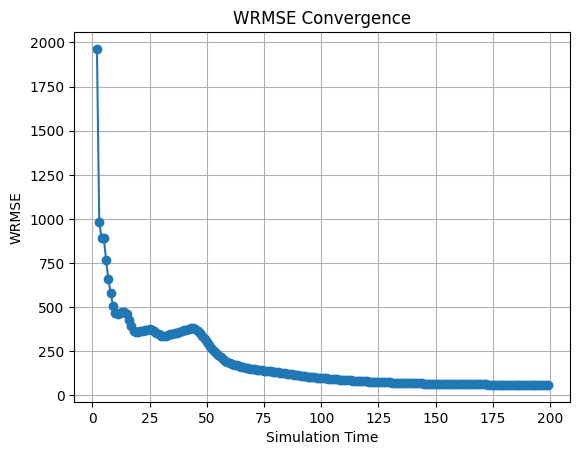

In [ ]:
plt.plot(sim_times, wrmse_values, marker='o')
plt.xlabel('Simulation Time')
plt.ylabel('WRMSE')
plt.title('WRMSE Convergence')
plt.grid(True)
plt.show()

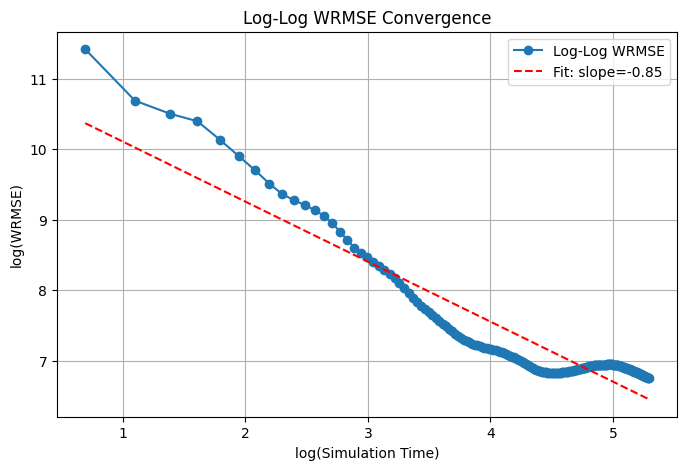

Оценка скорости сходимости (наклон): -0.85


In [ ]:
import scipy.stats as stats

log_sim_times = np.log(sim_times[1:])
log_wrmse_values = np.log(wrmse_values[1:])

# Линейная регрессия на логарифмических данных
slope, intercept, r_value, p_value, std_err = stats.linregress(log_sim_times, log_wrmse_values)

# Визуализация логарифмического графика
plt.figure(figsize=(8, 5))
plt.plot(log_sim_times, log_wrmse_values, marker='o', linestyle='-', label='Log-Log WRMSE')
plt.plot(log_sim_times, intercept + slope * log_sim_times, 'r--', label=f'Fit: slope={slope:.2f}')
plt.xlabel('log(Simulation Time)')
plt.ylabel('log(WRMSE)')
plt.title('Log-Log WRMSE Convergence')
plt.legend()
plt.grid(True)
plt.show()

print(f"Оценка скорости сходимости (наклон): {slope:.2f}")

In [ ]:
def calculate_wrmse_without_var(N_exper, Wq_exper, N_teor, Wq_teor):
    return np.sqrt(((N_exper - N_teor)**2 + (Wq_exper - Wq_teor)**2))

In [ ]:
wrmse_values = []
sim_times = []
weight_variance = 0.1

for i in range(1, 500):
    sim_times.append(i)
    random.seed(RANDOM_SEED)
    env = simpy.Environment()
    env.process(setup(env, NUM_MACHINES, WASHTIME, lamda))
    env.run(until=i)
    N_exper, Wq_exper= calculate_metrics_without_var(wait_times, system_occupancy_with_times)
    wrmse = calculate_wrmse_without_var(N_exper, Wq_exper, 20/9, 2/9)
    wrmse_values.append(wrmse)


Выходные данные были обрезаны до нескольких последних строк (5000).
Carwash removed Car 979's dirt.
Car 979 leaves the carwash at 336.82.
Car 980 enters the carwash at 337.53.
Carwash removed Car 980's dirt.
Car 980 leaves the carwash at 337.70.
Car 981 enters the carwash at 337.90.
Carwash removed Car 981's dirt.
Car 981 leaves the carwash at 338.16.
Car 982 enters the carwash at 338.16.
Carwash removed Car 978's dirt.
Car 978 leaves the carwash at 338.71.
Car 983 enters the carwash at 338.71.
Car 986 leaves without washing (queue full) at 339.87.
Carwash removed Car 982's dirt.
Car 982 leaves the carwash at 339.93.
Car 984 enters the carwash at 339.93.
Carwash removed Car 983's dirt.
Car 983 leaves the carwash at 340.19.
Car 985 enters the carwash at 340.19.
Carwash removed Car 984's dirt.
Car 984 leaves the carwash at 340.57.
Car 987 enters the carwash at 340.57.
Car 990 leaves without washing (queue full) at 341.08.
Car 991 leaves without washing (queue full) at 341.18.
Carwash rem

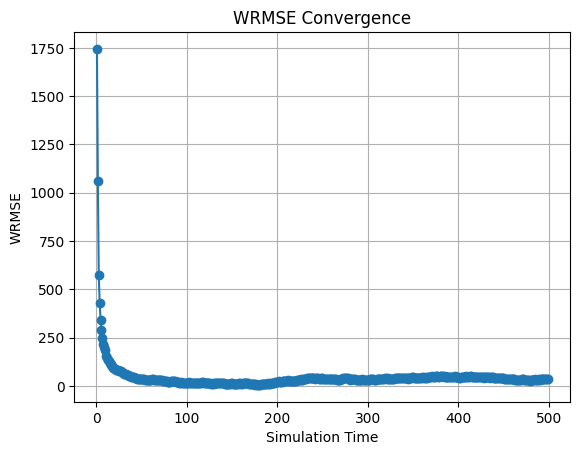

In [ ]:
plt.plot(sim_times, wrmse_values, marker='o')
plt.xlabel('Simulation Time')
plt.ylabel('WRMSE')
plt.title('WRMSE Convergence')
plt.grid(True)
plt.show()

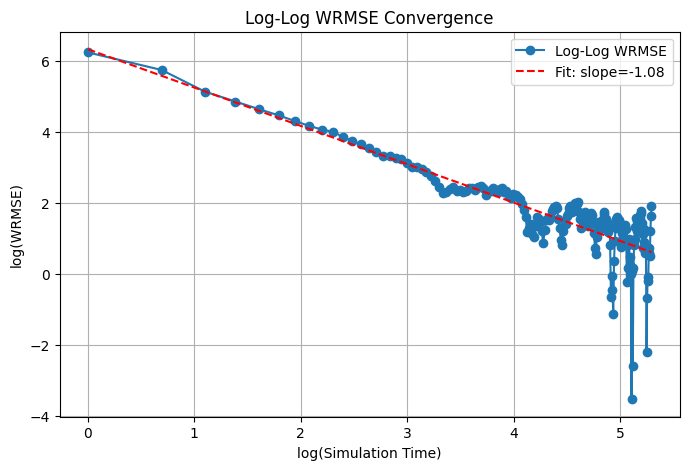

Оценка скорости сходимости (наклон): -1.08


In [ ]:
#оценка сходимости

log_sim_times = np.log(sim_times)
log_wrmse_values = np.log(wrmse_values)

# Линейная регрессия на логарифмических данных
slope, intercept, r_value, p_value, std_err = stats.linregress(log_sim_times, log_wrmse_values)

# Визуализация логарифмического графика
plt.figure(figsize=(8, 5))
plt.plot(log_sim_times, log_wrmse_values, marker='o', linestyle='-', label='Log-Log WRMSE')
plt.plot(log_sim_times, intercept + slope * log_sim_times, 'r--', label=f'Fit: slope={slope:.2f}')
plt.xlabel('log(Simulation Time)')
plt.ylabel('log(WRMSE)')
plt.title('Log-Log WRMSE Convergence')
plt.legend()
plt.grid(True)
plt.show()

print(f"Оценка скорости сходимости (наклон): {slope:.2f}")